### <div style="text-align: center">ISYE 6740 Fall 2020 - Project Report - Part2 </div> 


<div style="text-align: center; font-size:120%">Andrea Koltai, Peter Kovari</div><div style="text-align: center; font-size:100%">akoltai3@gatech.edu, pkovari3@gatech.edu</div><br>


<div style="text-align: center; font-size: 120%"> 12/08/2020</div>


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### Import files

In [186]:
Xtrain = pd.read_csv('data/Xtrain.csv', index_col=0)
ytrain = pd.read_csv('data/ytrain.csv', index_col=0).iloc[:,0]
Xval = pd.read_csv('data/Xval.csv', index_col=0)
yval = pd.read_csv('data/yval.csv', index_col=0).iloc[:,0]
Xtest = pd.read_csv('data/Xtest.csv', index_col=0)
ytest = pd.read_csv('data/ytest.csv', index_col=0).iloc[:,0]


print(f'Train set:      {Xtrain.shape},  labels:  {ytrain.shape}')
print(f'Validation set:  {Xval.shape},  labels:  {yval.shape}')
print(f'Test set:        {Xtest.shape},  labels:  {ytest.shape}\n')

print(f'Fraud in train:      {ytrain.mean(): .2%}')
print(f'Fraud in validation: {yval.mean(): .2%}')
print(f'Fraud in test:        {ytest.mean():.2%}')

Train set:      (170883, 30),  labels:  (170883,)
Validation set:  (56962, 30),  labels:  (56962,)
Test set:        (56962, 30),  labels:  (56962,)

Fraud in train:       0.17%
Fraud in validation:  0.17%
Fraud in test:        0.17%


In [187]:
feats = Xtrain.columns.tolist()
print(feats)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'scaled_amount', 'scaled_hour']


### My helper functions

In [188]:
def disp_conf_matrix(true, pred):
    df = pd.DataFrame(confusion_matrix(true, pred), columns=['Pred_0', 'Pred_1'], index=['True_0', 'True_1'])
    display(df)

**Report format:**

If you train your model and hyperparameter tuning is involved:
* train the model on `Xtrain`, `ytrain` dataset
* make prediction using `Xval` --> `pred_val`
* calculate `f1_score(yval, pred_val)` 
* choose the parameters with the highest f1 score
* make prediction on test set `Xtest` --> `pred_test`
* evaluate the model performance on the test set:     
```print(classification_report(ytest, pred_test, digits=3))```    
and   
```disp_conf_matrix(ytest, pred_test)```

If no hyperparameter tuning is needed, just skip the 2-4 steps.

## Local Outlier Factors

In [18]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score

In [7]:
Xtrain.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,scaled_amount,scaled_hour
count,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,...,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000
mean,0.003147,-0.001898,0.001950,0.004090,-0.003149,0.004458,-0.001669,0.001006,0.000891,0.000716,...,0.000222,0.001887,0.000190,0.000257,0.001420,-0.000786,0.000038,0.000221,0.930737,-0.002037
std,1.947743,1.624640,1.513050,1.416873,1.377727,1.332696,1.240109,1.194033,1.098450,1.083764,...,0.729931,0.725090,0.612063,0.604886,0.522012,0.481902,0.405023,0.329751,3.509061,1.000913
min,-41.928738,-63.344698,-48.325589,-5.683171,-113.743307,-21.929312,-43.557242,-73.216718,-13.434066,-24.588262,...,-34.830382,-10.933144,-36.666000,-2.836627,-7.025783,-2.534330,-9.895244,-15.430084,-0.307413,-2.406930
25%,-0.921446,-0.603316,-0.887702,-0.843867,-0.695125,-0.764927,-0.556571,-0.207071,-0.643386,-0.534114,...,-0.227260,-0.538983,-0.162018,-0.352402,-0.316792,-0.327657,-0.070380,-0.053101,-0.229861,-0.693382
50%,0.020714,0.062948,0.180697,-0.014567,-0.057063,-0.271016,0.036713,0.023549,-0.051505,-0.091425,...,-0.028911,0.009686,-0.011293,0.041112,0.018588,-0.053805,0.001430,0.011163,0.000000,0.163392
75%,1.316773,0.800219,1.026223,0.747037,0.610331,0.401192,0.567041,0.328807,0.598322,0.456439,...,0.187260,0.529492,0.148108,0.437804,0.352340,0.239357,0.090650,0.078021,0.780409,0.848811
max,2.451888,22.057729,4.079168,16.715537,32.911462,73.301626,120.589494,19.587773,10.348407,15.245686,...,27.202839,10.503090,22.083545,4.584549,7.519589,3.517346,31.612198,22.620072,358.683155,1.534230


#### Establishing Training Data for the LocalOutlierFactor model

The LocalOutlierFactor model will be trained on inlier (valid credit card transaction) data points only from the test dataset:

In [217]:
Xtrain_valid = Xtrain[ytrain == 0]
Xtrain_invalid = Xtrain[ytrain == 1]

In [218]:
print(Xtrain.shape, Xtrain_valid.shape, Xtrain_invalid.shape)

(170883, 30) (170588, 30) (295, 30)


#### Training the LocalOutlierFactor model

First, we train the LocalOutlierFactor model with the following parameters: 

    - n_neighbors = 10 - setting the number of k=10 for the k-nearest-neighbors portion of the algorithm - comparing local densities with that of the nearest 10 neighbors for each datapoint - to be optimized below.
    - novelty=False - this sets the model in outlier-detection mode
    - n_jobs = 8 - using 8 available processor cores for more efficient computation.


In [219]:
%%time

LOF = LocalOutlierFactor(n_neighbors = 10, n_jobs=8, novelty=False)
LOF.fit(Xtrain_valid) 


CPU times: user 38min 49s, sys: 0 ns, total: 38min 49s
Wall time: 4min 59s


LocalOutlierFactor(n_jobs=8, n_neighbors=10)

In [220]:
# Setting the model into "novelty" mode:
if 'novelty' in LOF.get_params():
    LOF.set_params(novelty=True)

pred_val= LOF.predict(Xval) 

# Changing predicted labels to be consistent with the original dataset's labels

# Valid CC transaction labels are labeled as 0 in the original dataset: 
pred_val[pred_val == 1] = 0 
# Fraudulent CC transaction labels are labeled as 1 in the original dataset: 
pred_val[pred_val == -1] = 1 

errors_val = (pred_val != yval).sum() 
print("Number of total errors:", errors_val)
print("Accuracy score: ", accuracy_score(yval, pred_val))
print(classification_report(yval, pred_val))


Number of total errors: 2688
Accuracy score:  0.9528106456936203
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     56863
           1       0.01      0.31      0.02        99

    accuracy                           0.95     56962
   macro avg       0.51      0.63      0.50     56962
weighted avg       1.00      0.95      0.97     56962



#### Finding the optimal hyper-parameter for LocalOutierFactor

We try various "number of neighbors" parameter values for the LocalOutlierFactor model:

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

pred_validation = [pred_val == 1] = -1 
pred_validation = pred_val[pred_val == 0] =  1 

num_of_neighbors = [3,5,10,15,20,15,30,50]
tuned_parameters = {'n_neighbors' : num_of_neighbors}

for score in range(1):  #scores
    clf =  GridSearchCV(LOF, tuned_parameters, cv=5,
                           scoring=make_scorer(accuracy_score), return_train_score=True, n_jobs=8)    
    clf.fit(Xval, pred_validation)

    resultDf = pd.DataFrame(clf.cv_results_)
    print(resultDf[["mean_test_score", "std_test_score", "params"]].sort_values(by=["mean_test_score"], ascending=False).head())
    print()
    print("Best parameters set found on cross-validation set:")
    print()
    print(clf.best_params_)

#### (Re-)Training the LocalOutlierFactor model with the optimal k=50 number of neighbors parameter:

In [51]:
%%time

LOF = LocalOutlierFactor(n_neighbors = 50, n_jobs=8, novelty=False)
LOF.fit(Xtrain_valid) 

CPU times: user 58min 47s, sys: 17.3 s, total: 59min 5s
Wall time: 7min 37s


LocalOutlierFactor(n_jobs=8, n_neighbors=50)

In [52]:
if 'novelty' in LOF.get_params():
    LOF.set_params(novelty=True)

pred_test= LOF.predict(Xtest) 

In [53]:
pred_test[pred_test == 1] = 0 
pred_test[pred_test == -1] = 1 


errors_test = (pred_test != ytest).sum() 
print("Number of total errors:", errors_test)
print("Accuracy score: ", accuracy_score(ytest, pred_test))
print(classification_report(ytest, pred_test))

Number of total errors: 1708
Accuracy score:  0.9700150977844879
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.05      0.91      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.94      0.54     56962
weighted avg       1.00      0.97      0.98     56962



Refering back to the results of the previous models in the first portion of the 'Project', the following features have the most amount of predictive power: V10, V12, V14, V16, V17

#### Running LocalOutlier factor with select features

In [65]:
LOF.fit(Xtrain_valid[["V10", "V12", "V14", "V16", "V17", "scaled_amount", "scaled_hour"]]) 

LocalOutlierFactor(n_jobs=8, n_neighbors=50, novelty=True)

In [66]:
if 'novelty' in LOF.get_params():
    LOF.set_params(novelty=True)
pred_test= LOF.predict(Xtest[["V10", "V12", "V14", "V16", "V17", "scaled_amount", "scaled_hour"]]) 

In [67]:
pred_test[pred_test == 1] = 0 
pred_test[pred_test == -1] = 1 

errors_test = (pred_test != ytest).sum() 
print("Number of total errors:", errors_test)
print("Accuracy score: ", accuracy_score(ytest, pred_test))
print(classification_report(ytest, pred_test))

Number of total errors: 471
Accuracy score:  0.9917313296583687
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.16      0.89      0.27        98

    accuracy                           0.99     56962
   macro avg       0.58      0.94      0.63     56962
weighted avg       1.00      0.99      0.99     56962



While the 16% precision rate for the fraudulent transactions (label = 1) is quite low, the 89% recall is very promising. This indicates, that 89% of fraudulent transactions will be called as fraudulent by this model, and 'only' 11% will 'fall through the cracks'. Precision at 16% means that only 16% of all transactions flagged by this model as fraudulent are in fact fraudulent.

This high recall value is a much more important from a business perspective than the precision score - in the case of credit card fraud detection, since the monetary cost of (even manually / in person over the phone) validating or potentially throwing away initiated credit card transactions flagged by this candidate model of ours is usually lower than the cost of allowing fraudulent transaction. 


## Isolation Forest

In [74]:
import sklearn
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, f1_score
from sklearn import model_selection
from sklearn.model_selection import train_test_split

#### Running model with Default Parameters

In [75]:
model = IsolationForest(n_estimators=100, random_state=0, contamination=ytrain.mean() )
model.fit(Xtrain_valid)


IsolationForest(contamination=0.0017263273701889597, random_state=0)

In [76]:
ypred_test = model.predict(Xtest)

In [77]:
ypred_test[ypred_test == 1] = 0 
ypred_test[ypred_test == -1] = 1 

In [79]:
errors_test = (ypred_test != ytest).sum() 
print("Number of total errors:", errors_test)
print("Accuracy score: ", accuracy_score(ytest, ypred_test))
print(classification_report(ytest, ypred_test))

Number of total errors: 178
Accuracy score:  0.996875109722271
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.21      0.31      0.25        98

    accuracy                           1.00     56962
   macro avg       0.61      0.65      0.63     56962
weighted avg       1.00      1.00      1.00     56962



Results are pretty weak, only a F1 =0.25 with very low recall and precision.

#### Running model with Default Parameters and the previously identified features only:

In [80]:
model.fit(Xtrain_valid[["V10", "V12", "V14", "V16", "V17"]])

IsolationForest(contamination=0.0017263273701889597, random_state=0)

In [81]:
ypred_test = model.predict(Xtest[["V10", "V12", "V14", "V16", "V17"]])
ypred_test[ypred_test == 1] = 0 
ypred_test[ypred_test == -1] = 1 
errors_test = (ypred_test != ytest).sum() 
print("Number of total errors:", errors_test)
print("Accuracy score: ", accuracy_score(ytest, ypred_test))
print(classification_report(ytest, ypred_test))

Number of total errors: 112
Accuracy score:  0.9980337769039008
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.46      0.84      0.59        98

    accuracy                           1.00     56962
   macro avg       0.73      0.92      0.80     56962
weighted avg       1.00      1.00      1.00     56962



#### Performing grid-search for finding optimal hyper-parameters: 

In [171]:
cont = ytrain.mean()
model = IsolationForest(random_state=0, n_jobs=10, contamination=ytrain.mean())

param_grid = {
                'n_estimators': list(range(100, 400, 50)),
                'max_features': [1,2,5,10,20,30],
#                'contamination': [0.001, 0.0017, 0.005, 0.01, 0.1]
                'bootstrap': [True, False],
                'max_samples': list(range(100, 500, 50))
            }

In [175]:
cv=[(slice(None), slice(None))]   #Turning off cross-validation, performing GridSearch only.
        #See:  https://stackoverflow.com/questions/44636370/scikit-learn-gridsearchcv-without-cross-validation-unsupervised-learning#44682305
f1sc = make_scorer(f1_score, average='micro')

IF_GridSearchCV = model_selection.GridSearchCV(model, 
                                                 param_grid,
                                                 scoring=f1sc, 
                                                 refit=True,
#                                                 cv=10,
                                                 cv=cv,
                                                 return_train_score=True,
                                                 n_jobs=-1
                                              )

In [173]:
ytrain_rs = ytrain.values.reshape(ytrain.shape[0],1)
Xy = np.concatenate((Xtrain, ytrain_rs), axis=1)
df = pd.DataFrame(data=Xy)
Xy_sample = df.sample(frac=0.1)
ytrain_sample = Xy_sample.iloc[:,-1]
Xtrain_sample = Xy_sample.iloc[:,:-1]


ytrain_sample[ytrain_sample == 1] = -1 
ytrain_sample[ytrain_sample == 0] =  1 

In [174]:
%%time
IF_GridSearchCV.fit(Xtrain_sample, ytrain_sample)

resultDf = pd.DataFrame(IF_GridSearchCV.cv_results_)
print(resultDf[["mean_test_score", "std_test_score", "params"]].sort_values(by=["mean_test_score"], ascending=False).head(), "\n")
print("Best parameters set found on cross-validation set:\n")
print(IF_GridSearchCV.best_params_)



     mean_test_score  std_test_score  \
414         0.997776             0.0   
426         0.997776             0.0   
384         0.997659             0.0   
390         0.997659             0.0   
408         0.997659             0.0   

                                                params  
414  {'bootstrap': False, 'max_features': 5, 'max_s...  
426  {'bootstrap': False, 'max_features': 5, 'max_s...  
384  {'bootstrap': False, 'max_features': 5, 'max_s...  
390  {'bootstrap': False, 'max_features': 5, 'max_s...  
408  {'bootstrap': False, 'max_features': 5, 'max_s...   

Best parameters set found on cross-validation set:

{'bootstrap': False, 'max_features': 5, 'max_samples': 350, 'n_estimators': 100}
CPU times: user 6.98 s, sys: 436 ms, total: 7.42 s
Wall time: 9min 53s


Let us see how our model performs with these newly found (semi-)optimal hyper-parameters: 'bootstrap': False, 'max_features': 5, 'max_samples': 350, 'n_estimators': 100

#### Running Isolation Forest model with Optimal hyper-parameters: 

In [176]:
modelOptimal = IsolationForest(n_estimators=100, contamination=ytrain.mean(), max_samples=350, max_features=5, random_state=0, n_jobs=-1)
modelOptimal.fit(Xtrain)

IsolationForest(contamination=0.0017263273701889597, max_features=5,
                max_samples=350, n_jobs=-1, random_state=0)

In [177]:
ypred_test = modelOptimal.predict(Xtest)

In [178]:
ypred_test[ypred_test == 1] = 0 
ypred_test[ypred_test == -1] = 1 
errors_test = (ypred_test != ytest).sum() 
print("Number of total errors:", errors_test)
print("Accuracy score: ", accuracy_score(ytest, ypred_test))
print(classification_report(ytest, ypred_test))

Number of total errors: 146
Accuracy score:  0.9974368877497279
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.30      0.36      0.32        98

    accuracy                           1.00     56962
   macro avg       0.65      0.68      0.66     56962
weighted avg       1.00      1.00      1.00     56962



In [189]:
disp_conf_matrix(ytest, ypred_test)

,Pred_0,Pred_1
True_0,56831,33
True_1,20,78


F1 score came out to 0.32, somewhat higher than the naive approach, but still much lower than F1=59 in the case of using the selected features only with the non-optimized model. 


#### Running Isolation Forest model with Optimal hyper-parameters __and__ the selected features: 

In [180]:
modelOptimal.fit(Xtrain[["V10", "V12", "V14", "V16", "V17"]])

IsolationForest(contamination=0.0017263273701889597, max_features=5,
                max_samples=350, n_jobs=-1, random_state=0)

In [181]:
ypred_test = modelOptimal.predict(Xtest[["V10", "V12", "V14", "V16", "V17"]])
ypred_test[ypred_test == 1] = 0 
ypred_test[ypred_test == -1] = 1 
errors_test = (ypred_test != ytest).sum() 
print("Number of total errors:", errors_test)
print("Accuracy score: ", accuracy_score(ytest, ypred_test))
print(classification_report(ytest, ypred_test))

Number of total errors: 53
Accuracy score:  0.9990695551420246
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.70      0.80      0.75        98

    accuracy                           1.00     56962
   macro avg       0.85      0.90      0.87     56962
weighted avg       1.00      1.00      1.00     56962



In [191]:
disp_conf_matrix(ytest, ypred_test)

,Pred_0,Pred_1
True_0,56831,33
True_1,20,78


F1=0.75 is the best score we found so far - using our optimized parameters __and__ the selected set of features. In this case we have an 80% recall and 70% precision, these are in the range of practical applicability in the setting of a credit card processing operation. 

## ANN - Artificial Neural Network


Using a Keras Sequential ANN model (with TensorFlow backend)

Based on: 
https://www.codespeedy.com/the-sequential-model-in-keras-in-python/ and 
https://medium.com/analytics-vidhya/credit-card-fraud-detection-c66d1399c0b7

In [199]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

import numpy as np

#getting the features and target from the DF-s:
features = np.array(Xtrain)
target = ytrain

#converting target column into categories
from keras.utils import to_categorical
target=to_categorical(target)

In [200]:
np.version.version

'1.19.2'

In [201]:
model = Sequential([
    Dense(units=16, activation='relu', input_dim=30),
    Dense(units=24, activation='relu'), 
    Dropout(0.5),
    Dense(units=20, activation='relu'), 
    Dense(units=24, activation='relu'), 
    Dense(2,activation='softmax')
])

In [202]:
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [19]:
#compile and fit the model
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])
model.fit(features,target,validation_split = 0.2,epochs = 10,batch_size = 128)

Epoch 1/10
1069/1069 [==============================] - 1629s 2s/step - loss: 0.0295 - accuracy: 0.9971 - val_loss: 0.0052 - val_accuracy: 0.9990
Epoch 2/10
1069/1069 [==============================] - 1818s 2s/step - loss: 0.0053 - accuracy: 0.9990 - val_loss: 0.0039 - val_accuracy: 0.9993
Epoch 3/10
1069/1069 [==============================] - 1857s 2s/step - loss: 0.0041 - accuracy: 0.9993 - val_loss: 0.0039 - val_accuracy: 0.9994
Epoch 4/10
1069/1069 [==============================] - 1828s 2s/step - loss: 0.0038 - accuracy: 0.9993 - val_loss: 0.0040 - val_accuracy: 0.9993
Epoch 5/10
1069/1069 [==============================] - 1835s 2s/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 0.0039 - val_accuracy: 0.9993
Epoch 6/10
1069/1069 [==============================] - 1830s 2s/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 0.0039 - val_accuracy: 0.9994
Epoch 7/10
1069/1069 [==============================] - 1859s 2s/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 0.0049 -

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 16)                496       
_________________________________________________________________
dense_6 (Dense)              (None, 24)                408       
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 20)                500       
_________________________________________________________________
dense_8 (Dense)              (None, 24)                504       
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 50        
Total params: 1,958
Trainable params: 1,958
Non-trainable params: 0
____________________________________________________

In [24]:
ytest_target=to_categorical(ytest)

In [25]:
score = model.evaluate(Xtest, ytest_target)

1781/1781 [==============================] - 2044s 1s/step - loss: 0.0024 - accuracy: 0.9995


In [26]:
print(score)

[0.002385556697845459, 0.9995260238647461]


In [203]:
from tensorflow.keras.models import Sequential, save_model, load_model

In [28]:
# To save the model run this: 
# (make sure the "saved_model" folder/directory exists at the path of this current .ipynb file )
filepath = './saved_model'
save_model(model, filepath)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./saved_model/assets


In [204]:
# Load reload the model from file run this cell: 
filepath = './saved_model'
model = load_model(filepath, compile = True)

In [205]:
%%time
pred_test = model.predict(Xtest)

CPU times: user 3h 31s, sys: 2h 49min 14s, total: 5h 49min 46s
Wall time: 29min 48s


In [206]:
pred_test_collapsed = np.argmax(pred_test, axis = 1)

In [207]:
errors_test = (pred_test_collapsed != ytest).sum() 
print("Number of total errors:", errors_test)
print("Accuracy score: ", accuracy_score(ytest, pred_test_collapsed))
print(classification_report(ytest, pred_test_collapsed))

Number of total errors: 27
Accuracy score:  0.9995259997893332
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.87      0.86        98

    accuracy                           1.00     56962
   macro avg       0.93      0.93      0.93     56962
weighted avg       1.00      1.00      1.00     56962



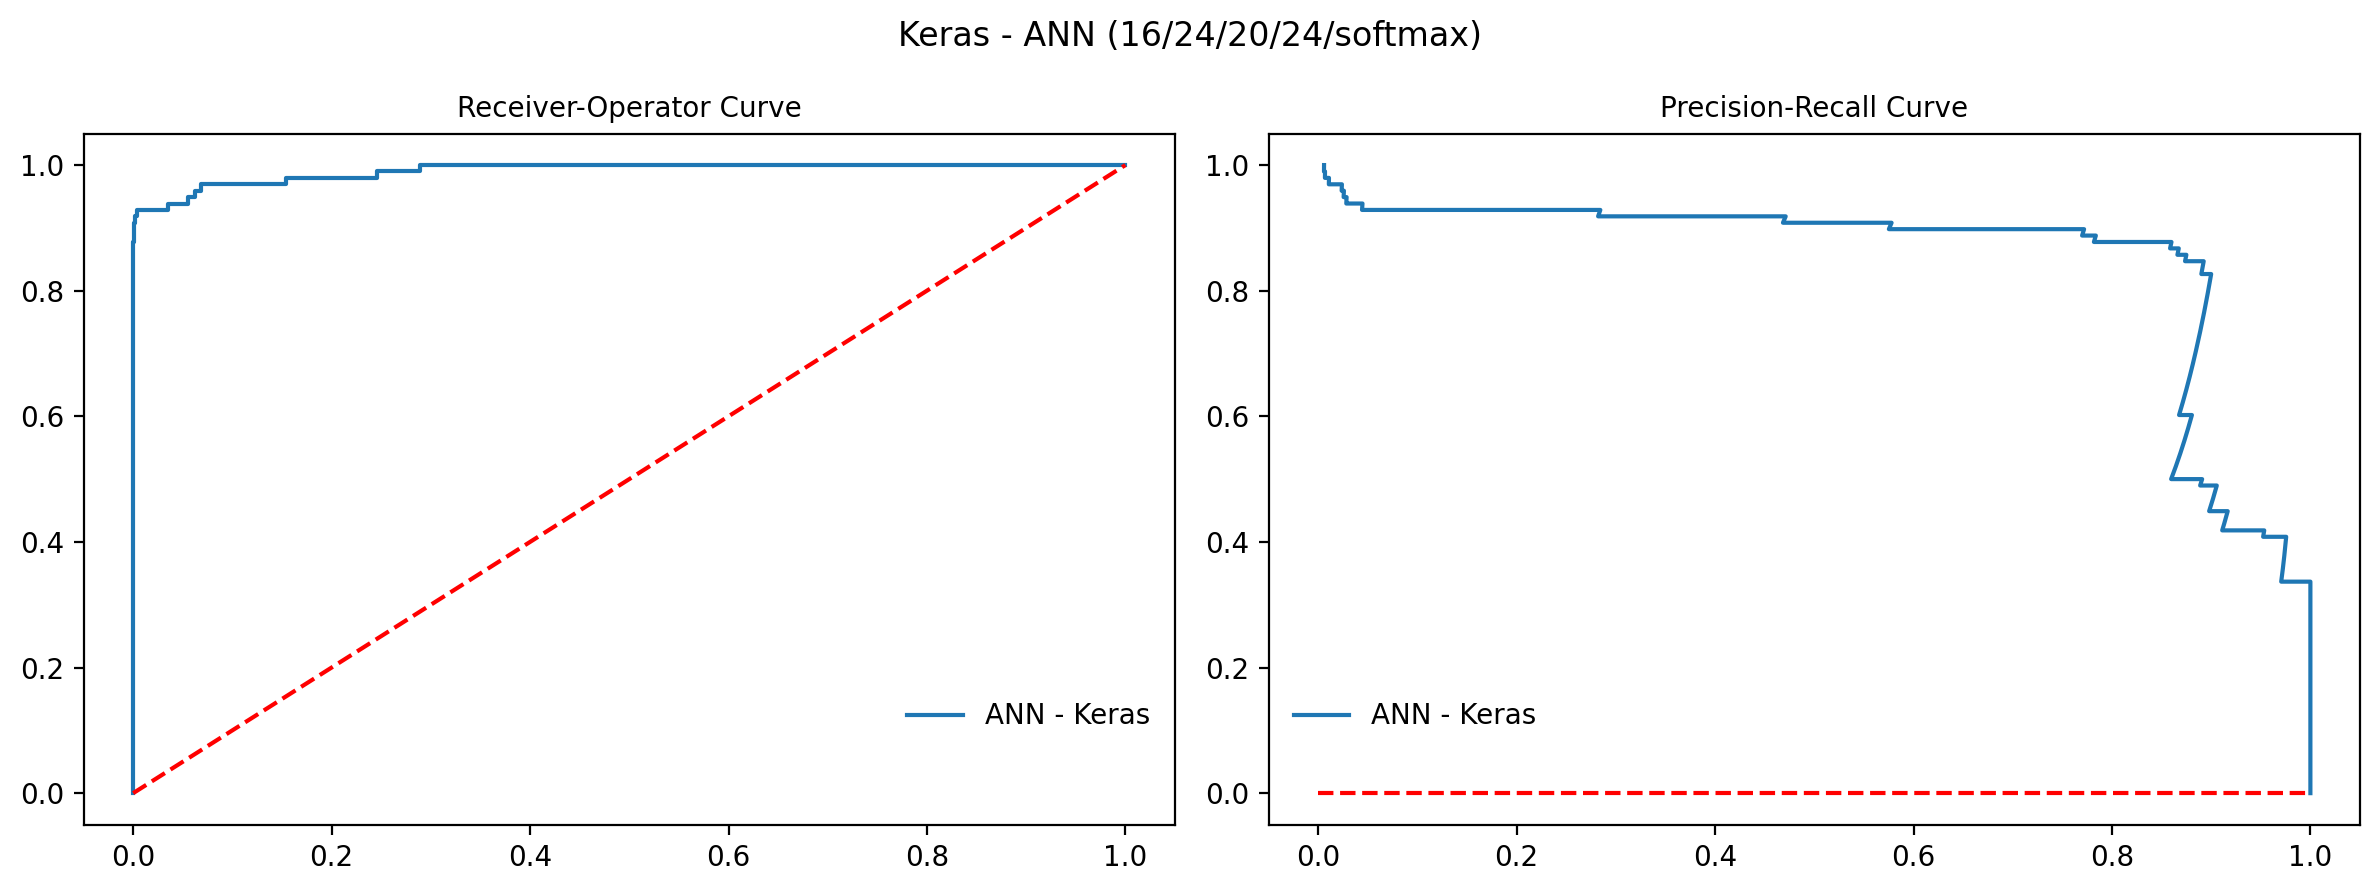

In [215]:
plot_roc_prc2([model],pred_test,  ['ANN - Keras'], 'img/ROC_nn.png', 'Keras - ANN (16/24/20/24/softmax)');

In [214]:
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score


# modified version of plot_roc_prc2() 
def plot_roc_prc2(clfs, pred_test, names, save_path=None, suptitle=None, ):
    '''Given the list of classifiers, displays the ROC and Precision-Recall Curve w.r.t. the test set'''
    assert len(clfs) == len(names)
    
    fig, (ax1, ax2) =  plt.subplots(1,2, figsize=(12,4.5), dpi=200)
    
    for i in range(len(clfs)): 
        pred_test_proba = pred_test[:,1]  #replaced predict_proba()
        precision, recall, t_prcurve = precision_recall_curve(ytest, pred_test_proba)
        fpr, tpr, t_roccurve = roc_curve(ytest, pred_test_proba)

        ax1.plot(fpr, tpr, label=names[i])
        ax1.set_title('Receiver-Operator Curve', fontsize=10)
        ax1.plot([0,1], [0,1], linestyle='--', c='r')

        ax2.plot(precision, recall, label=names[i])
        ax2.set_title('Precision-Recall Curve', fontsize=10)
        ax2.plot([0,1], [0,0], linestyle='--', c='r')


    ax1.legend(frameon=False, loc='lower right', bbox_to_anchor=(1, 0.1))
    ax2.legend(frameon=False, loc='lower left', bbox_to_anchor=(0, 0.1))
    
    if suptitle:
        plt.suptitle(suptitle, fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, transparent=False, dpi=200, facecolor='white')
        
    plt.show()